In [ ]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)

purchase_data = pd.read_csv('/content/drive/MyDrive/exp_data/purchase_data_v1.csv', sep=',', parse_dates=True, infer_datetime_format=True)
purchase_data.head()

,date,uid,sku,price
0,2017-07-10,41195147,sku_three_499,499
1,2017-07-15,41195147,sku_three_499,499
2,2017-11-12,41195147,sku_four_599,599
3,2017-09-26,91591874,sku_two_299,299
4,2017-12-01,91591874,sku_four_599,599


In [ ]:
customer_demographics = pd.read_csv('/content/drive/MyDrive/exp_data/user_demographics_v1.csv', sep=',', parse_dates=True, infer_datetime_format=True)
# reg_date : registration date
customer_demographics.head()

,uid,reg_date,device,gender,country,age
0,54030035.0,2017-06-29T00:00:00Z,and,M,USA,19
1,72574201.0,2018-03-05T00:00:00Z,iOS,F,TUR,22
2,64187558.0,2016-02-07T00:00:00Z,iOS,M,USA,16
3,92513925.0,2017-05-25T00:00:00Z,and,M,BRA,41
4,99231338.0,2017-03-26T00:00:00Z,iOS,M,FRA,59


In [ ]:
purchase_data = purchase_data.merge(
    customer_demographics,
    how="inner",
    on=["uid"]
)
purchase_data.head()

,date,uid,sku,price,reg_date,device,gender,country,age
0,2017-07-10,41195147,sku_three_499,499,2017-06-26T00:00:00Z,and,M,BRA,17
1,2017-07-15,41195147,sku_three_499,499,2017-06-26T00:00:00Z,and,M,BRA,17
2,2017-11-12,41195147,sku_four_599,599,2017-06-26T00:00:00Z,and,M,BRA,17
3,2017-09-26,91591874,sku_two_299,299,2017-01-05T00:00:00Z,and,M,TUR,17
4,2017-12-01,91591874,sku_four_599,599,2017-01-05T00:00:00Z,and,M,TUR,17


In [ ]:
current_date = pd.to_datetime("2018-03-17")

In [ ]:
# Ex: 2017-06-29T00:00:00Z
purchase_data.reg_date = pd.to_datetime(purchase_data.reg_date, format="%Y-%m-%dT%H:%M:%SZ")
# Ex: 2017-07-10
purchase_data.date = pd.to_datetime(purchase_data.date, format="%Y-%m-%d")

# Key Performance Indicators: Measuring Business Success

## Average amount paid per purchase within a user's first 28 days

We'll calculate the **average amount paid per purchase** within a user's first **28 days** using the `purchase_data` `DataFrame` from before.  
This KPI can provide a sense of the popularity of different in-app purchase price points to users within their first month.

In [ ]:
from datetime import timedelta

# Compute max_purchase_date
max_purchase_date = current_date - timedelta(days=28)

# Filter to only include users who registered before our max date
purchase_data_filt = purchase_data[purchase_data.reg_date < max_purchase_date]

# Filter to contain only purchases within the first 28 days of registration
purchase_data_filt = purchase_data_filt[(purchase_data_filt.date <= 
                        purchase_data_filt.reg_date + timedelta(days=28))]

# Output the mean price paid per purchase
print(purchase_data_filt.price.mean())

414.4237288135593


Interesting! Since our average price is **414** cents which is below **$4.99** it seems that our purchasers tend towards the lower priced set of options.

## Average purchase price by cohort

**Average purchase price by cohort**
- let's look at the same KPI, average purchase price, and a similar one, median purchase price, **within the first 28 days**. 
    - Additionally, let's look at these metrics not limited to 28 days to compare.
- We can calculate these **metrics across a set of cohorts** and see what differences emerge. This is a useful task as it can help us understand how behaviors vary across cohorts.

In [ ]:
import numpy as np

# Set the max registration date to be one month before today
max_reg_date = current_date - timedelta(days=28)
# Find the month 1 values
month1 = np.where((purchase_data.reg_date < max_reg_date) &
                 (purchase_data.date < purchase_data.reg_date + timedelta(days=28)),
                  purchase_data.price, 
                  np.NaN)
                 
# Update the value in the DataFrame
purchase_data['month1'] = month1
# Group the data by gender and device 
purchase_data_upd = purchase_data.groupby(by=['gender', 'device'], as_index=False) 
# Aggregate the month1 and price data 
purchase_summary = purchase_data_upd.agg(
                        {'month1': ['mean', 'median'],
                        'price': ['mean', 'median']})
# Examine the results 
print(purchase_summary)

  gender device      month1              price       
                       mean median        mean median
0      F    and  388.204545  299.0  400.747504    299
1      F    iOS  432.587786  499.0  404.435330    299
2      M    and  413.705882  399.0  416.237308    499
3      M    iOS  433.313725  499.0  405.272401    299


This value seems relatively **stable over the past 28 days**. 
- `month1`: price limited to 28 days
- `price`: price not limited to 28 days

**Summary**: 
- We saw mean purchase price on **first 28 days** registration was about 414 cents.
- This amount broken by `gender` and `device` doesn't move much over the **past 28 days**.
    - So we have **generalizability** of these statistics **across different demographic groups**
    - and **Stability** (so we don t need custom KPIs for each breakdown)

That's why **mean purchase price on first 28 days** is a good KPI candidate.  
Another example of KPI we could use would be the **conversion rate**. We should only need to look at what interval to consider (One week after the event? One month?)


Next we'll explore the data after having changed in-app purchase pricing to increase the mean number of purchases of first week users.

# Exploring and Visualizing Customer Behavior

In trying to boost purchases, we have made some changes to our introductory **in-app purchase pricing**.   
We will check if this is having an impact on the number of purchases made by purchasing users during their first week.

In [ ]:
# mask_first_week_purchases = purchase_data.date - purchase_data.reg_date <= timedelta(days=7)
# purchase_data.loc[mask_first_week_purchases, "first_week_purchases"] = 1
# purchase_data.loc[~mask_first_week_purchases, "first_week_purchases"] = 0
# user_purchases = purchase_data[purchase_data.reg_date > pd.to_datetime("2017-06-01")]

In [ ]:
user_purchases_raw = pd.read_csv('/content/drive/MyDrive/exp_data/user_purchases_chapter_two_exercise_one.csv', sep=',', parse_dates=True, infer_datetime_format=True)
user_purchases_raw.head()

,Unnamed: 0,date,uid,sku,price,reg_date,device,gender,country,age,first_week_purchases
0,0,2018-03-14,84715271.0,sku_two_299,299,2018-03-09,and,M,USA,34,1
1,1,2018-03-16,84715271.0,sku_two_299,299,2018-03-09,and,M,USA,34,1
2,7,2018-01-14,47315877.0,sku_three_499,499,2018-01-07,iOS,F,BRA,15,1
3,8,2018-01-15,47315877.0,sku_one_199,199,2018-01-07,iOS,F,BRA,15,0
4,9,2018-01-16,47315877.0,sku_two_299,299,2018-01-07,iOS,F,BRA,15,0


In [ ]:
import matplotlib.pyplot as plt

# Group the data and aggregate first_week_purchases
user_purchases = user_purchases_raw.groupby(by=['reg_date', 'uid']).agg({'first_week_purchases': ['sum']})
user_purchases.head()

first_week_purchases
                                       sum
reg_date   uid                            
2017-06-01 14425628.0                    1
           33027560.0                    0
           39880095.0                    2
           46080210.0                    1
           48166079.0                    0

In [ ]:
# Reset the indexes
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)
user_purchases.head()

,reg_date,uid,first_week_purchases
0,2017-06-01,14425628.0,1
1,2017-06-01,33027560.0,0
2,2017-06-01,39880095.0,2
3,2017-06-01,46080210.0,1
4,2017-06-01,48166079.0,0


In [ ]:
# Find the average number of purchases per day by first-week users
user_purchases = user_purchases.groupby(by=['reg_date']).agg({'first_week_purchases': ['mean']})
user_purchases.head()

,first_week_purchases
,mean
reg_date,
2017-06-01,0.846154
2017-06-02,1.333333
2017-06-03,1.352941
2017-06-04,1.727273
2017-06-05,1.666667


In [ ]:
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)
user_purchases.head()

,reg_date,first_week_purchases
0,2017-06-01,0.846154
1,2017-06-02,1.333333
2,2017-06-03,1.352941
3,2017-06-04,1.727273
4,2017-06-05,1.666667


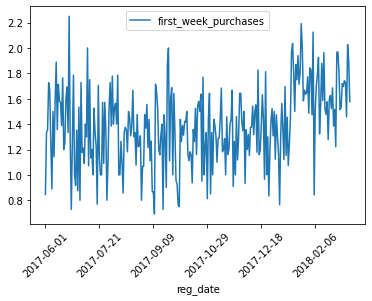

In [ ]:
# Plot the results
user_purchases.plot(x="reg_date", y="first_week_purchases")
plt.xticks(rotation=45)
plt.show()

There does indeed seem to be a substantial increase in the average number of first week purchases.

## Confirm that this is not driven only by one segment of users

Let's now confirm that this is not driven only by one segment of users.  
- We'll do this by first pivoting our data by 'country' and then by 'device'. Our change is designed to impact all of these groups equally.

### By country

In [ ]:
# Group the data and aggregate first_week_purchases
user_purchases_country = user_purchases_raw.groupby(by=['reg_date', 'uid', 'country']).agg({'first_week_purchases': ['sum']})
user_purchases_country.head()

first_week_purchases
                                               sum
reg_date   uid        country                     
2017-06-01 14425628.0 TUR                        1
           33027560.0 TUR                        0
           39880095.0 BRA                        2
           46080210.0 USA                        1
           48166079.0 TUR                        0

In [ ]:
# Reset the indexes
user_purchases_country.columns = user_purchases_country.columns.droplevel(level=1)
user_purchases_country.reset_index(inplace=True)
user_purchases_country.head()

,reg_date,uid,country,first_week_purchases
0,2017-06-01,14425628.0,TUR,1
1,2017-06-01,33027560.0,TUR,0
2,2017-06-01,39880095.0,BRA,2
3,2017-06-01,46080210.0,USA,1
4,2017-06-01,48166079.0,TUR,0


In [ ]:
# Pivot the data
country_pivot = pd.pivot_table(user_purchases_country, values=['first_week_purchases'], 
                               columns=['country'], index=['reg_date'])
country_pivot.head()

first_week_purchases                                             
country                     BRA  CAN       DEU       FRA       TUR       USA
reg_date                                                                    
2017-06-01             1.500000  NaN  1.000000  0.000000  0.333333  1.200000
2017-06-02             2.000000  NaN  0.500000       NaN  1.000000  1.428571
2017-06-03             1.000000  2.0  1.500000  1.333333  3.000000  1.200000
2017-06-04             4.000000  NaN  1.333333  4.000000       NaN  1.166667
2017-06-05             1.666667  NaN       NaN       NaN  2.000000  1.000000

### By device

In [ ]:
# Group the data and aggregate first_week_purchases
user_purchases_device = user_purchases_raw.groupby(by=['reg_date', 'uid', 'device']).agg({'first_week_purchases': ['sum']})

# Reset the indexes
user_purchases_device.columns = user_purchases_device.columns.droplevel(level=1)
user_purchases_device.reset_index(inplace=True)
user_purchases_device.head()

,reg_date,uid,device,first_week_purchases
0,2017-06-01,14425628.0,and,1
1,2017-06-01,33027560.0,and,0
2,2017-06-01,39880095.0,iOS,2
3,2017-06-01,46080210.0,and,1
4,2017-06-01,48166079.0,iOS,0


In [ ]:
# Pivot the data
device_pivot = pd.pivot_table(user_purchases_device, values=['first_week_purchases'], columns=['device'], index=['reg_date'])
print(device_pivot.head())

           first_week_purchases          
device                      and       iOS
reg_date                                 
2017-06-01             0.714286  1.000000
2017-06-02             1.400000  1.285714
2017-06-03             1.545455  1.000000
2017-06-04             1.600000  1.833333
2017-06-05             1.625000  2.000000


Next we will plot the data which should illuminate anything interesting in the data:

In [ ]:
# Reset the indexes
country_pivot.columns = country_pivot.columns.droplevel(level=0)
country_pivot.reset_index(inplace=True)
country_pivot.head()

country,reg_date,BRA,CAN,DEU,FRA,TUR,USA
0,2017-06-01,1.500000,NaN,1.000000,0.000000,0.333333,1.200000
1,2017-06-02,2.000000,NaN,0.500000,NaN,1.000000,1.428571
2,2017-06-03,1.000000,2.0,1.500000,1.333333,3.000000,1.200000
3,2017-06-04,4.000000,NaN,1.333333,4.000000,NaN,1.166667
4,2017-06-05,1.666667,NaN,NaN,NaN,2.000000,1.000000


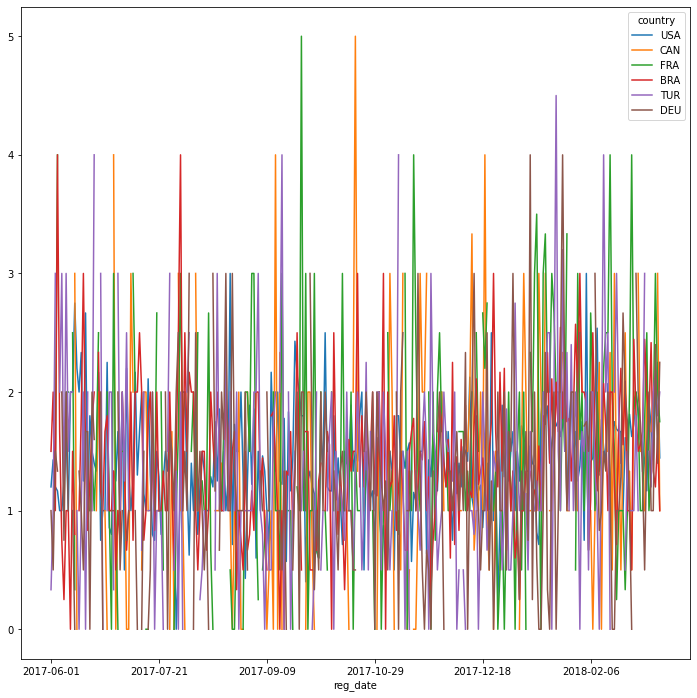

In [ ]:
# Plot the average first week purchases for each country by registration date
country_pivot.plot(x='reg_date', y=['USA', 'CAN', 'FRA', 'BRA', 'TUR', 'DEU'], figsize=(12, 12))
plt.show()

In [ ]:
# Reset the indexes
device_pivot.columns = device_pivot.columns.droplevel(level=0)
device_pivot.reset_index(inplace=True)
device_pivot.head()

device,reg_date,and,iOS
0,2017-06-01,0.714286,1.000000
1,2017-06-02,1.400000,1.285714
2,2017-06-03,1.545455,1.000000
3,2017-06-04,1.600000,1.833333
4,2017-06-05,1.625000,2.000000


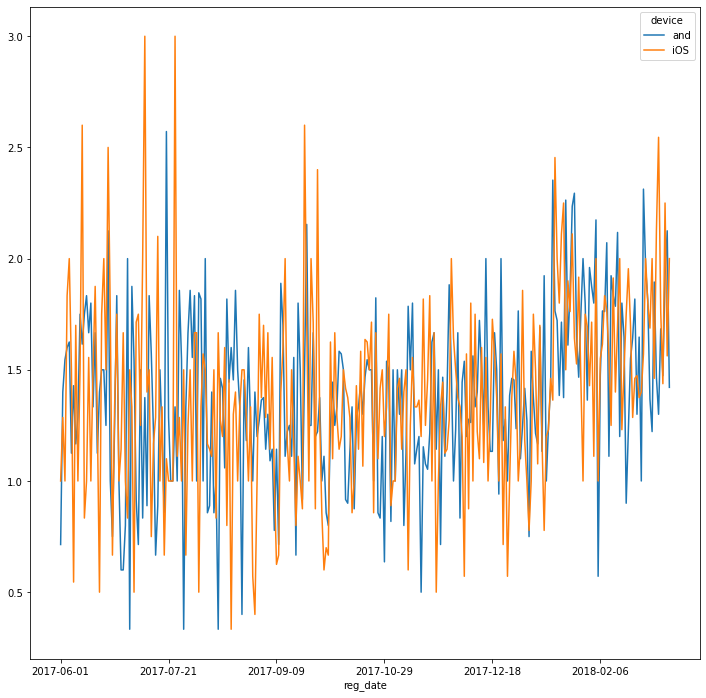

In [ ]:
# Plot the average first week purchases for each device by registration date
device_pivot.plot(x='reg_date', y=['and', 'iOS'], figsize=(12, 12))
plt.show()

It looks like our change is causing the observed result.

## Understanding and visualizing trends

Plotting a graph is not enough and additional preprocessing is required to uncover the trend.  
For a given day we'll look at the nb of subscribers who registered within the prior week.

Stepping back, we will now look at the overall revenue data for our meditation app. 
- We saw **strong purchase growth in one of our products**, and now we want to see if that is **leading to a corresponding rise in revenue**.  

As you may expect, revenue is very **seasonal**, so we want to correct for that and unlock macro trends.

In [ ]:
daily_revenue_raw = pd.read_csv('/content/drive/MyDrive/exp_data/daily_revenue.csv', sep=',', parse_dates=True, infer_datetime_format=True)

In [ ]:
daily_revenue = daily_revenue_raw[["revenue", "date"]].drop_duplicates()

In [ ]:
# Setup 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
# daily_revenue = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/datasets/daily_revenue.csv'
# urlretrieve(daily_revenue, 'daily_revenue.csv')
# daily_revenue = pd.read_csv('daily_revenue.csv')
daily_revenue.date = pd.to_datetime(daily_revenue.date)
daily_revenue = daily_revenue.groupby(by=['date'], as_index = False)
daily_revenue = daily_revenue.agg({'revenue': ['sum']})
daily_revenue.columns = daily_revenue.columns.droplevel(1)
daily_revenue.head()

,date,revenue
0,2013-09-20 00:00:00+00:00,1040405.0
1,2013-09-21 00:00:00+00:00,998827.0
2,2013-09-22 00:00:00+00:00,950908.0
3,2013-09-23 00:00:00+00:00,890947.0
4,2013-09-24 00:00:00+00:00,942562.0


In [ ]:
# Trailing averages to smooth data
# Compute 7_day_rev: average over the past 10-days
daily_revenue['7_day_rev'] = daily_revenue.revenue.rolling(window=7,center=False).mean()

# Compute 28_day_rev
daily_revenue['28_day_rev'] = daily_revenue.revenue.rolling(window=28,center=False).mean()

# Compute 365_day_rev
daily_revenue['365_day_rev'] = daily_revenue.revenue.rolling(window=365,center=False).mean()
    
daily_revenue.head()

,date,revenue,7_day_rev,28_day_rev,365_day_rev
0,2013-09-20 00:00:00+00:00,1040405.0,NaN,NaN,NaN
1,2013-09-21 00:00:00+00:00,998827.0,NaN,NaN,NaN
2,2013-09-22 00:00:00+00:00,950908.0,NaN,NaN,NaN
3,2013-09-23 00:00:00+00:00,890947.0,NaN,NaN,NaN
4,2013-09-24 00:00:00+00:00,942562.0,NaN,NaN,NaN


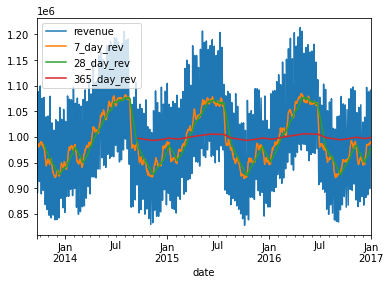

In [ ]:
# Plot date, and revenue, along with the 3 rolling functions (in order)    
daily_revenue.plot(x='date', y=['revenue', '7_day_rev', '28_day_rev', '365_day_rev'])
plt.show()

Notice that while there is a lot of seasonality, our revenue seems to be somewhat flat over this time period.

We saw that our revenue is somewhat flat over time. In this exercise we will dive deeper into the data to see if we can determine why this is the case. 
- We will look at the revenue for a single in-app purchase product we are selling to see if this potentially reveals any trends. 
- As this will have less data then looking at our overall revenue it will be much noisier. To account for this we will smooth the data using an exponential rolling average.

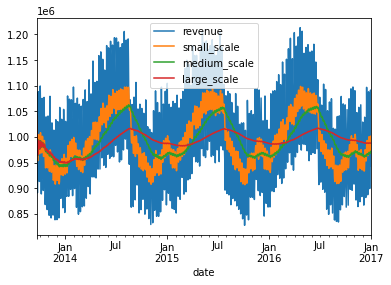

In [ ]:
# smoothing with exponential moving average: weights recent items in the window more
# Calculate 'small_scale': exponential average over the past 10-days
daily_revenue['small_scale'] = daily_revenue.revenue.ewm(span=10).mean()
# Calculate 'medium_scale'
daily_revenue['medium_scale'] = daily_revenue.revenue.ewm(span=100).mean()
# Calculate 'large_scale'
daily_revenue['large_scale'] = daily_revenue.revenue.ewm(span=500).mean()
# Plot 'date' on the x-axis and, our three averages and 'revenue'
# on the y-axis
daily_revenue.plot(x = 'date', y =['revenue', 'small_scale', 'medium_scale', 'large_scale'])
plt.show()

- Note that the medium window strikes the right balance. 
- Revenue seems to be growing in this product so it must not be the cause of the overall flat revenue trend

## Events and releases

Now, we will build on these skills and apply them to discover the cause of an issue in our app ecosystem.

Recently, the Product team made some big changes to both the Android & iOS apps. 
- They do not have any direct concerns about the impact of these changes, but want you to monitor the data to make sure that the changes don't hurt company revenue. 
- Additionally, the product team believes that some of these changes may impact female users more than male users.

We're going to plot the monthly revenue for one of the updated products and evaluate the results.

In [ ]:
user_revenue = daily_revenue_raw.copy()
# Ex: 2017-06-29T00:00:00Z
user_revenue.date = pd.to_datetime(user_revenue.date, format="%Y-%m-%dT%H:%M:%SZ")
user_revenue.rename(columns={'date': 'month'}, inplace=True)

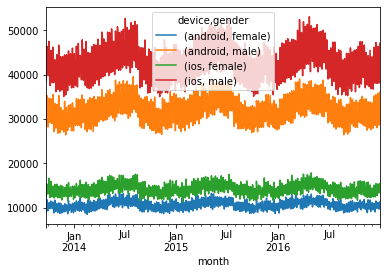

In [ ]:
# Pivot user_revenue
pivoted_data = pd.pivot_table(user_revenue, values ='revenue', columns=['device', 'gender'], index='month')
pivoted_data = pivoted_data[1:(len(pivoted_data) -1 )]
# Create and show the plot
pivoted_data.plot()
plt.show()

In [ ]:
pivoted_data.head()

device      android               ios         
gender       female     male   female     male
month                                         
2013-09-21  10857.5  31765.7  14601.1  42658.4
2013-09-22   9487.0  30783.9  13244.3  41575.6
2013-09-23   9145.6  28967.6  12446.6  38534.9
2013-09-24  10159.5  30438.4  13592.7  40065.6
2013-09-25  11223.6  31554.5  13943.3  41924.6

From this view, it seems like our aggregate revenue is fairly stable, so the changes are most likely not hurting revenue.

# The Design and Application of A/B Testing

- We are going to check what happens when we add a consumable paywall to our app. 
    - A paywall is a feature of a website or other technology that requires payment from users in order to access additional content or services.

- Here, you'll practice calculating experimental units and baseline values related to our consumable paywall. 
    - Both measure revenue only among users who viewed a paywall. 
Your job is to calculate revenue per user-day, with user-day as the experimental unit.

In [ ]:
# Extract the 'day'; value from the timestamp
purchase_data.date = purchase_data.date.dt.floor('d')
# Replace the NaN price values with 0 
purchase_data.price = np.where(np.isnan(purchase_data.price), 0, purchase_data.price)
# Aggregate the data by 'uid' & 'date'
purchase_data_agg = purchase_data.groupby(by=['uid', 'date'], as_index=False)
revenue_user_day = purchase_data_agg.sum()
revenue_user_day.head()

,uid,date,price,age,month1
0,11158549,2017-09-25,499,18,0.0
1,11158549,2017-12-02,599,18,0.0
2,11158549,2018-02-11,599,18,0.0
3,11158549,2018-03-13,299,18,0.0
4,11158549,2018-03-16,299,18,0.0


In [ ]:
# Calculate the final average
revenue_user_day = revenue_user_day.price.mean()
revenue_user_day

407.95033407572384

Values such as these will provide helpful context as you prepare your experiment. Now lets learn how to run an A/B test.

We will work with the **conversion rate** metric we explored in first chapter. 
- Specifically you will work to examine 
    - what that value becomes under different **percentage lifts** 
    - and look at **how many more conversions per day** this change would result in.

First you will find the average number of paywall views and purchases that were made per day in our observed sample

In [ ]:
## Load the libararies
import pandas as pd 
import numpy as np 
import scipy as sci
from scipy import stats
import pandas as pd 
import numpy as np 
import scipy as sci
from scipy import stats
from urllib.request import urlretrieve

demographics_data = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/datasets/chapter_three_lesson_three_exercise_one_user_demographics_paywall.csv'
urlretrieve(demographics_data, 'demographics_data.csv')
demographics_data = pd.read_csv('demographics_data.csv')
demographics_data.reg_date = pd.to_datetime(demographics_data.reg_date)

paywall_views  = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_6165/datasets/chapter_three_lesson_three_exercise_one_paywall_data.csv'
urlretrieve(paywall_views , 'paywall_views.csv')
paywall_views  = pd.read_csv('paywall_views.csv')
paywall_views.date = pd.to_datetime(paywall_views.date)

In [ ]:
demographics_data.head()

,uid,reg_date,device,gender,country,age
0,52774929,2018-03-07 00:00:00+00:00,and,F,FRA,27
1,40143397,2016-07-02 00:00:00+00:00,and,F,DEU,56
2,89856430,2017-06-05 00:00:00+00:00,and,M,TUR,31
3,76188504,2016-09-24 00:00:00+00:00,iOS,M,BRA,54
4,76493748,2017-06-07 00:00:00+00:00,iOS,M,BRA,24


In [ ]:
paywall_views.head()

,uid,date,purchase,sku,price
0,32209877,2016-12-04 14:20:49+00:00,0,NaN,NaN
1,32209877,2016-12-05 22:17:12+00:00,0,NaN,NaN
2,32209877,2016-12-09 17:56:09+00:00,0,NaN,NaN
3,32209877,2016-12-13 03:07:08+00:00,0,NaN,NaN
4,32209877,2016-12-14 17:19:29+00:00,0,NaN,NaN


In [ ]:
# Merge and group the datasets
purchase_data = demographics_data.merge(paywall_views,  how='inner', on=['uid'])
purchase_data.date = purchase_data.date.dt.floor('d')
# Group and aggregate our combined dataset 
daily_purchase_data = purchase_data.groupby(by=['date'], as_index=False)
daily_purchase_data = daily_purchase_data.agg({'purchase': ['sum', 'count']})
# Find the mean of each field and then multiply by 1000 to scale the result
daily_purchases = daily_purchase_data.purchase['sum'].mean()
daily_paywall_views = daily_purchase_data.purchase['count'].mean()
daily_purchases = daily_purchases * 1000
daily_paywall_views = daily_paywall_views * 1000
print(daily_purchases)
print(daily_paywall_views)

3181.8181818181815
91731.86409550045


## Evaluating different sensitivities

Continuing with the conversion rate metric, we will now utilize the previous results to evaluate a few potential sensitivities that we could make use of in planning our experiment.

In [ ]:
# Finding our baseline conversion rate
# conversion rate = total purchases / total paywall views
conversion_rate = (sum(purchase_data.purchase) / purchase_data.purchase.count())
print(conversion_rate)

0.03468607351645712


In [ ]:
small_sensitivity = 0.1 
# Find the conversion rate when increased by the percentage of the sensitivity above
small_conversion_rate = conversion_rate * (1 + small_sensitivity) 
# Apply the new conversion rate to find how many more users per day that translates to
small_purchasers = daily_paywall_views * small_conversion_rate
# Subtract the initial daily_purcahsers number from this new value to see the lift
purchaser_lift = small_purchasers - daily_purchases
print(small_conversion_rate)
print(small_purchasers)
print(purchaser_lift)

0.038154680868102836
3500.0000000000005
318.1818181818189


In [ ]:
medium_sensitivity = 0.2
# Find the conversion rate when increased by the percentage of the sensitivity above
medium_conversion_rate = conversion_rate * (1 + medium_sensitivity) 
# Apply the new conversion rate to find how many more users per day that translates to
medium_purchasers = daily_paywall_views * medium_conversion_rate
# Subtract the initial daily_purcahsers number from this new value to see the lift
purchaser_lift = medium_purchasers - daily_purchases
print(medium_conversion_rate)
print(medium_purchasers)
print(purchaser_lift)

0.04162328821974854
3818.181818181818
636.3636363636365


In [ ]:
large_sensitivity = 0.5
# Find the conversion rate lift with the sensitivity above
large_conversion_rate = conversion_rate * (1 + large_sensitivity)
# Find how many more users per day that translates to
large_purchasers = daily_paywall_views * large_conversion_rate
purchaser_lift = large_purchasers - daily_purchases
print(large_conversion_rate)
print(large_purchasers)
print(purchaser_lift)

0.05202911027468568
4772.727272727273
1590.9090909090914


While it seems that a 50% increase may be too drastic and unreasonable to expect, the **small** and **medium** sensitivities both seem very reasonable.

In [ ]:
# Find the number of paywall views 
n = purchase_data.purchase.count()

# Calculate the quantitiy "v"
# This is the variance of the percentage of successes in binomial
# Here, binomial because how many successes in n experiments? 
# And we don't know the prior probability to have success.
# We only know the percentage of success among our n experiments.
v = conversion_rate * (1 - conversion_rate) 
# Calculate the variance and standard error of the estimate
var = v / n
se = var**0.5
print(var)
print(se)

3.351780834114284e-07
0.0005789456653360731


In [ ]:
avg_purchases = purchase_data.purchase.mean()
print(se / avg_purchases)

0.01669101188583329


Our std is over 1% of what our mean is. So it seems pretty good.

Notice how closely the **standard error** is related to our **sample size**?

## Calculating sample size

In [ ]:
p1 = 0.1
p2 = 0.12
cl = 0.95
n1 = 1000

def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    
    qu = stats.norm.ppf(1 - alpha/2)
    
    diff = abs(p2 - p1)
    bp = (p1 + p2) / 2
    
    v1 = p1 * (1 - p1)
    v2 = p2 * (1 - p2)
    
    bv = bp * (1 - bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    
    power = power_part_one + power_part_two
    return(power)

In [ ]:
# Look at the impact of sample size increase on power
n_param_one = get_power(n=1000, p1=p1, p2=p2, cl=cl)
n_param_two = get_power(n=2000, p1=p1, p2=p2, cl=cl)
# Look at the impact of confidence level increase on power
alpha_param_one = get_power(n=n1, p1=p1, p2=p2, cl=0.8)
alpha_param_two = get_power(n=n1, p1=p1, p2=p2, cl=0.95)

In [ ]:
# Compare the ratios
print(n_param_two / n_param_one)
print(alpha_param_one / alpha_param_two)

1.7596440001351992
1.8857367092232278


With these particular values it looks like **decreasing our confidence level** 
has a slightly **larger impact on the power** than **increasing our sample size**.  
You're now going to utilize the sample size function to determine how many users you need for the test and control groups under various circumstances.

In [ ]:
def get_sample_size(power, p1, p2, cl, max_n=1000000):
    n = 1 
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)
        if tmp_power >= power: 
            return n
        else: 
            n = n + 100
    return "Increase Max N Value"

In [ ]:
# Find the conversion rate
conversion_rate = (sum(purchase_data.purchase) / purchase_data.purchase.count())
            
print(conversion_rate)

0.03468607351645712


Using the `conversion_rate` value you found, calculate **p2**, the baseline increased by the percent lift listed.

In [ ]:
# Find the conversion rate
conversion_rate = (sum(purchase_data.purchase) / purchase_data.purchase.count())
# Desired Power: 0.8
# CL: 0.90
# Percent Lift: 0.1
p2 = conversion_rate * (1 + 0.1)
sample_size = get_sample_size(0.8, conversion_rate, p2, 0.90)
print(sample_size)

36101


In [ ]:
# Desired Power: 0.95
# CL 0.90
# Percent Lift: 0.1
p2 = conversion_rate * (1 + 0.1)
sample_size = get_sample_size(0.95, conversion_rate, p2, 0.90)
print(sample_size)

63201


# Analyzing A/B Testing Results

We will confirm that everything ran correctly for an A/B test.   
Thi one consists of trying to boost consumable sales through making changes to a paywall.

In [ ]:
ab_test_results = pd.read_csv('/content/drive/MyDrive/exp_data/AB_testing_exercise.csv', sep=',', parse_dates=True, infer_datetime_format=True)
ab_test_results.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [ ]:
# Compute and print the results
results = ab_test_results.groupby('group').agg({'uid':pd.Series.nunique}) 
print(results)

         uid
group       
GRP A  23009
GRP B  22874


Now we convert this number to the percentage of overall users in each group.  
This will help in presenting the result and speaking about it precisely.

In [ ]:
# Find the unique users in each group 
results = ab_test_results.groupby('group').agg({'uid': pd.Series.nunique}) 
# Find the overall number of unique users using "len" and "unique"
unique_users = len(ab_test_results.uid.unique()) 
# Find the percentage in each group
results = results / unique_users * 100
print(results)

             uid
group           
GRP A  50.147113
GRP B  49.852887


Finally, additionally group by **device** and **gender** when finding the number of users in each group.  
This will let us compute our percentage calculation broken out by **device** and **gender** to confirm our result is truly random across cohorts.

In [ ]:
# Find the unique users in each group, by device and gender
results = ab_test_results.groupby(by=['group', 'device', 'gender']).agg({'uid': pd.Series.nunique}) 
# Find the overall number of unique users using "len" and "unique"
unique_users = len(ab_test_results.uid.unique())
# Find the percentage in each group
results = results / unique_users * 100
print(results)

                           uid
group device gender           
GRP A A      F       12.239827
             M       12.795589
      I      F       12.542772
             M       12.568925
GRP B A      F       12.553669
             M       12.499183
      I      F       12.283417
             M       12.516618


Looks like we are ready to proceed with our analysis.

## Understanding statistical significance

**p-value**: value as or more extreme than our observation if the **Null Hypothesis** is true

We will work to gain an intuitive understanding of statistical significance. 
- We will do this by utilizing the `get_pvalue()` function on a variety of parameter sets that could reasonably arise or be chosen during the course of an A/B test. 
- While doing this we should be observing how statistical significance results vary as you change the parameters. 
- This will help build our intuition surrounding this concept, and reveal some of the subtle pitfalls of **p-values**. 

In [ ]:
def get_pvalue(con_conv, test_conv, con_size, test_size):  
    lift =  - abs(test_conv - con_conv)

    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

In [ ]:
# Get the p-value
p_value = get_pvalue(con_conv=0.1, test_conv=0.17, con_size=1000, test_size=1000)
print(p_value)

4.131297741047306e-06


In [ ]:
# Get the p-value
p_value = get_pvalue(con_conv=0.1, test_conv=0.15, con_size=100, test_size=100)
print(p_value)

0.28366948940702086


In [ ]:
# Get the p-value
p_value = get_pvalue(con_conv=0.48, test_conv=0.50, con_size=1000, test_size=1000)
print(p_value)

0.370901935824383


We observed that 
- a **large lift** makes us **confident** in our observed result, 
- while a **small sample** size makes us **less so**,
- and ultimately **high variance** can lead to a **high p-value**

Find the **p-value** of our experiment:

In [ ]:
# control group conversion rate
cont_conv = 0.09096495570387314

# test group conversion rate
test_conv = 0.1020053238686779

cont_size = 5329
test_size = 5748

# Compute the p-value
p_value = get_pvalue(con_conv=cont_conv, test_conv=test_conv, con_size=cont_size, test_size=test_size)
print(p_value)
# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

0.04900185792087508
Significant Result


It looks like our result is significant. Now we can continue on to provide confidence intervals.

We'll develop our intuition for how various parameter values impact **confidence intervals**.  
Specifically, we will explore through the `get_ci()` function how changes widen or tighten the **confidence interval**. 

In [ ]:
import scipy.stats as sci

def get_ci(value, cl, sd):
  loc = sci.norm.ppf(1 - cl/2)
  rng_val = sci.norm.cdf(loc - value/sd)

  lwr_bnd = value - rng_val
  upr_bnd = value + rng_val 

  return_val = (lwr_bnd, upr_bnd)
  return(return_val)

In [ ]:
# Compute and print the confidence interval
confidence_interval  = get_ci(1, 0.975, 0.5)
print(confidence_interval)

(0.9755040421682947, 1.0244959578317054)


In [ ]:
# Compute and print the confidence interval
confidence_interval  = get_ci(1, 0.95, 2)
print(confidence_interval)

(0.6690506448818785, 1.3309493551181215)


In [ ]:
# Compute and print the confidence interval
confidence_interval  = get_ci(1, 0.95, 0.001 )
print(confidence_interval)

(1.0, 1.0)


As our **standard deviation decreases** so too does the **width of our confidence interval**.

Now we will calculate the confidence intervals for the A/B test results.

In [ ]:
cont_conv = 0.090965
test_conv = 0.102005
test_size = 56350
cont_size = 58583

# Calculate the mean of our lift distribution 
lift_mean = test_conv - cont_conv 
# Calculate variance and standard deviation 
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - cont_conv) * cont_conv / cont_size
lift_sd = lift_variance**0.5
# Find the confidence intervals with cl = 0.95
confidence_interval = get_ci(lift_mean, 0.95, lift_sd)
print(confidence_interval)

(0.011039999822042502, 0.011040000177957487)


This really provides great context to our results! Notice that our **interval is very narrow** thanks to our **substantial lift** and **large sample size**.

## Interpreting the results

**Obs**: conversion rate is a **percentage of successes in binomial**. If $np \geq 5$ and $n(1-p) \geq 5$ by **CLT**, where p is the conversion rate, then its distribution approximates a **normal distribution**.

We will visualize the **test** and **control** **conversion rates** as distributions. 
- It is helpful to practice what was covered in the example,
    - as this may be something we have not applied before.   

Additionally, viewing the data in this way can give a sense of the **variability inherent in our estimation**.

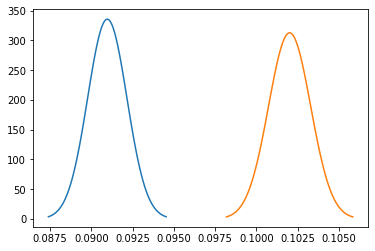

In [ ]:
from scipy.stats import norm

cont_var = 1.411507925080655e-06
test_var = 1.6255542142857143e-06

# Compute the standard deviations
control_sd = cont_var**0.5
test_sd = test_var**0.5
# Create the range of x values 
control_line = np.linspace( cont_conv - 3 * control_sd, cont_conv + 3 * control_sd , 100)
test_line = np.linspace( test_conv - 3 * test_sd,  test_conv + 3 * test_sd , 100)
# Plot the distribution 
plt.plot(control_line, norm.pdf(control_line, cont_conv, control_sd))
plt.plot(test_line, norm.pdf(test_line,test_conv, test_sd))
plt.show()

We see no overlap, which intuitively implies that our **test** and **control** **conversion rates** are **significantly distinct**.

Now lets plot the **difference distribution** of our results that is, the distribution of our lift.  

- Plot a **green vertical line** at the **distributions mean**, 
- and a **red vertical lines** at each of the **lower and upper confidence interval bounds**.

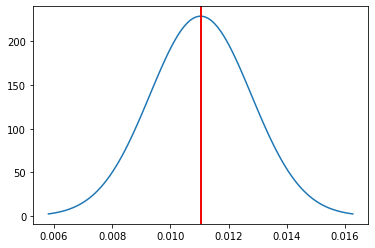

In [ ]:
lwr_ci = 0.01103999822042502
upr_ci = 0.011040000177957487

# Find the lift mean and standard deviation
lift_mean = test_conv - cont_conv
lift_sd = (test_var + cont_var) ** 0.5
# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)
# Plot the lift distribution
plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd))
# Add the annotation lines
plt.axvline(x = lift_mean, color = 'green')
plt.axvline(x = lwr_ci, color = 'red')
plt.axvline(x = upr_ci, color = 'red')
plt.show()

This really contextualizes the lift we observed and provides more information than reporting the numerical point estimate alone would.